In [67]:
import glob
import os
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import product
from statannotations.Annotator import Annotator
from scipy import stats

plt.style.use(["science", "nature"])
import pickle

plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 5
plt.rcParams['hatch.linewidth'] = 0.5

# %matplotlib widget

protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
    "annotation": "Annotated PAS",
    "Annotation": "Annotated PAS",
    "anno": "Annotated PAS",
}
type_map = {
    "Visium": "Spatial transcriptome",
    "VisiumHD": "Spatial transcriptome",
    "Chromium": "scRNA-seq",
    "Dropseq": "scRNA-seq",
    "Stereoseq": "Spatial transcriptome",
    "Slideseq": "Spatial transcriptome",
    "SpatialTranscriptomics": "Spatial transcriptome",
    "Microwell": "scRNA-seq",
}
order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]
# order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium", "10X Visium HD","Stereo-seq", "Slide-seq V2", "Spatial Transcriptomics"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]
palette=sns.color_palette(color, 7)
mm = 1/25.4

In [50]:
unmatch_motif_density_df = pd.read_csv("/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_density_unmatch.csv")
match_motif_density_df = pd.read_csv("/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_density_match.csv")
motif_density_df = pd.concat([unmatch_motif_density_df, match_motif_density_df])
motif_density_df["protocol"] = motif_density_df["protocol"].map(protocol_map)
motif_density_df = motif_density_df[motif_density_df["cs_read_num"] == "multi"]

In [57]:
motif_var_list = []
for motif_type in ["pas_major", "pas_other"]:
    for match_type in ["match", "unmatch"]:
            for utr_type in ["utr", "nonutr"]:
                for sample_id in motif_density_df["sample_id"].unique():
                    protocol = sample_id.split("_")[0]
                    motif_window = motif_density_df[(motif_density_df["motif"] == motif_type) & (motif_density_df["match_type"] == match_type) & (motif_density_df["utr_type"] == utr_type) & (motif_density_df["sample_id"] == sample_id)]
                    motif_window = motif_window[(motif_window["position"] >= -100) & (motif_window["position"] <= 0)]
                        # variance = np.sum(coverage * (np.repeat(np.arange(621).reshape(-1,1), coverage.shape[1], axis=1) - mean.reshape(1,-1))**2, axis=0) / total
                    mean = (motif_window["position"] * motif_window["density"]).sum() / motif_window["density"].sum()
                    variance = (motif_window["density"] *(motif_window["position"] - mean)**2).sum() / motif_window["density"].sum()
                    std = np.sqrt(variance)
                    motif_var_list.append({
                        "motif_type": motif_type,
                        "match_type": match_type,
                        "utr_type": utr_type,
                        "protocol": protocol,
                        "variance": variance,
                        "std": std,
                    })


/tmp/ipykernel_1643125/2739886843.py:10: RuntimeWarning: invalid value encountered in scalar divide
  mean = (motif_window["position"] * motif_window["density"]).sum() / motif_window["density"].sum()
/tmp/ipykernel_1643125/2739886843.py:11: RuntimeWarning: invalid value encountered in scalar divide
  variance = (motif_window["density"] *(motif_window["position"] - mean)**2).sum() / motif_window["density"].sum()


In [56]:
motif_var_df = pd.DataFrame(motif_var_list)
motif_var_df["type"] = motif_var_df["match_type"]  + "_" + motif_var_df["utr_type"]
motif_var_df["protocol"] = motif_var_df["protocol"].map(protocol_map)
motif_var_df["protocol"] = pd.Categorical(motif_var_df["protocol"], categories=order+["Annotated PAS"])

for _, row in motif_var_df[motif_var_df["std"].isna()].iterrows():
    motif_var_df.loc[_, "variance"] = motif_var_df[(motif_var_df["protocol"] == row["protocol"]) & (motif_var_df["type"] == row["type"]) & (motif_var_df["motif_type"] == row["motif_type"])]["variance"].mean()
    motif_var_df.loc[_, "std"] = motif_var_df[(motif_var_df["protocol"] == row["protocol"]) & (motif_var_df["type"] == row["type"]) & (motif_var_df["motif_type"] == row["motif_type"])]["std"].mean()

,motif_type,match_type,utr_type,protocol,variance,std,type
0,pas_major,match,utr,10X Chromium,212.703367,14.584353,match_utr
1,pas_major,match,utr,10X Chromium,213.795375,14.621743,match_utr
2,pas_major,match,utr,10X Chromium,233.113952,15.268070,match_utr
3,pas_major,match,utr,10X Chromium,242.154390,15.561311,match_utr
4,pas_major,match,utr,Drop-seq,180.492371,13.434745,match_utr
...,...,...,...,...,...,...,...
227,pas_other,unmatch,nonutr,10X Visium,793.587551,28.170686,unmatch_nonutr
228,pas_other,unmatch,nonutr,10X Visium,772.421863,27.792479,unmatch_nonutr
229,pas_other,unmatch,nonutr,10X Visium,732.391078,27.062725,unmatch_nonutr
230,pas_other,unmatch,nonutr,10X Visium,824.348765,28.711474,unmatch_nonutr


In [58]:
box_pairs = [
    ((protocol, "match_utr"), (protocol, "unmatch_utr")) for protocol in order
] + [
    ((protocol, "match_nonutr"), (protocol, "unmatch_nonutr")) for protocol in order
]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Stereo-seq_match_utr vs. Stereo-seq_unmatch_utr: Wilcoxon test (paired samples), P_val:2.344e-02 Stat=2.000e+00
Slide-seq V2_match_utr vs. Slide-seq V2_unmatch_utr: Wilcoxon test (paired samples), P_val:5.469e-02 Stat=4.000e+00
ST_match_utr vs. ST_unmatch_utr: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
Slide-seq V2_match_nonutr vs. Slide-seq V2_unmatch_nonutr: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
ST_match_nonutr vs. ST_unmatch_nonutr: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
10X Visium_match_utr vs. 10X Visium_unmatch_utr: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
Microwell-seq_match_nonutr vs. Microwell-seq_unmatch_nonutr: Wilcoxon test (paired samples), P_val:7.812e-03 Stat=0.000e+00
10X Visium_match_nonutr 

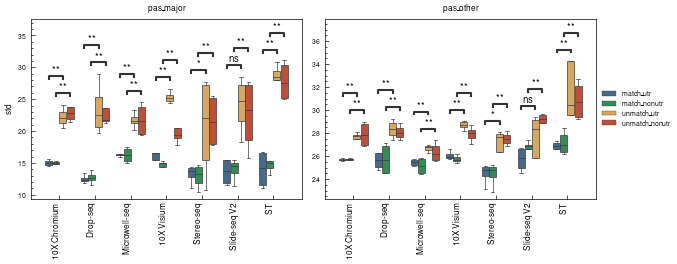

In [71]:
plt.close()
fig, axs = plt.subplots(1, 2, figsize=(175*mm, 70*mm))
for i, motif_type in enumerate(["pas_major", "pas_other"]):
    ax = axs[i]
    sns.boxplot(
        data=motif_var_df[(motif_var_df["protocol"] != "Annotated PAS") & (motif_var_df["motif_type"] == motif_type)],
        x="protocol",
        y="std",
        hue="type",
        order=order,
        hue_order=["match_utr", "match_nonutr", "unmatch_utr", "unmatch_nonutr"],
        palette=palette[0:4],
        ax=ax,
        showfliers=False,
    )
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
        ax.set_ylabel("")
    else:
        ax.legend().remove()
    ax.tick_params(which="minor", bottom=False)
    ax.set_xlabel("")
    ax.set_title(motif_type, fontsize=6)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right',fontsize=6)
    hue_plot_params = {
    'data': motif_var_df,
    'x': 'protocol',
    'y': 'std',
    "order": order,
    "hue": "type",
    "hue_order": ["match_utr", "match_nonutr", "unmatch_utr", "unmatch_nonutr"],
    "palette": palette,
    }
    annotator = Annotator(ax, box_pairs, **hue_plot_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()

plt.tight_layout()
plt.savefig("/root/apabenchmark/plot/fig3/motif_var.pdf", bbox_inches="tight", dpi=300)

In [65]:
cs_count_by_sample_df = pd.read_csv("/root/apabenchmark/data/raw_bam_feature/cs_count_by_sample.csv")
cs_count_df = pd.read_csv("/root/apabenchmark/data/raw_bam_feature/cs_count.csv")

IndexError: list index out of range

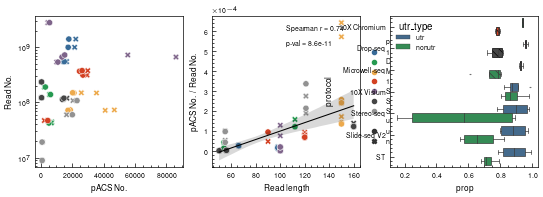

In [69]:
plt.close()
fig, (ax1,ax2, ax3)= plt.subplots(1,3, figsize=(165*mm,50*mm))

sns.scatterplot(
    data=cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="counts",
    y="read_count",
    hue="protocol",
    style="utr_type",
    hue_order=order,
    style_order=["utr","nonutr"],
    palette=palette,
    ax=ax1,
    legend=False,
    s=20
)
# ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("pACS No.")
ax1.set_ylabel("Read No.")


sns.scatterplot(
    data=cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="read_length",
    y="cs_by_read_counts",
    hue="protocol",
    style="utr_type",
    hue_order=order,
    style_order=["utr","nonutr"],
    palette=palette,
    ax=ax2,
    s=20
)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
# ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_xlabel("Read length")
ax2.set_ylabel("Efficiency")

sns.regplot(
    data = cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"],
    x="read_length",
    y="cs_by_read_counts",
    scatter=False,
    ax=ax2,
    color="black",
    
)
slope, intercept, r_value, p_value, std_err = stats.linregress(
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["read_length"],
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["cs_by_read_counts"]
    )
r2 = r_value**2
spearmanr, pval = stats.spearmanr(
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["read_length"],
    cs_count_by_sample_df[cs_count_by_sample_df["cs_read_num"] == "multi"]["cs_by_read_counts"]
    )
ax2.annotate(f"Spearman r = {spearmanr:.2f}", (0.5, 0.9), xycoords='axes fraction', fontsize=5)
ax2.annotate(f"p-val = {pval:.1e}",(0.5, 0.8),  xycoords='axes fraction', fontsize=5)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2.set_xlabel("Read length")
ax2.set_ylabel("pACS No. / Read No.")
ax2.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')

hatch_styles = ["\\\\\\\\", "////"]
colors = palette
alpha_values = [1, 0.7]

sns.boxplot(
    data=cs_count_df[(cs_count_df["match_type"] == "match") & (cs_count_df["cs_read_num"] == "multi")],
    x="prop",
    y="protocol",
    hue="utr_type",
    hue_order=["utr", "nonutr"],
    order=order,
    ax=ax3,
    # legend=False,
    palette=palette,
    flierprops={"markersize":0.2},
    width=0.8,)

for j, bar in enumerate(ax3.patches):
    hatch_index = j // (len(ax3.patches) // len(hatch_styles))
    bar.set_hatch(hatch_styles[hatch_index])
    bar.set_alpha(alpha_values[hatch_index])
    bar.set_facecolor(colors[j % (len(ax3.patches) // len(hatch_styles))])
    bar.set_edgecolor('black')  # 设置描边颜色为黑色
    bar.set_linewidth(0.5)  # 设置描边线宽为1
ax3.spines['top'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax3.set_xlabel("Matched pACS proportion")
ax3.set_ylabel("")
# move y-axis to the right
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
ax3.set_yticklabels(ax3.get_yticklabels(), fontsize=6)
ax3.tick_params(which="minor", right=False)
ax3.margins(y=0.06)
handles = [plt.Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='k', hatch=hatch_style) for i, hatch_style in enumerate(hatch_styles)]
labels = ["3'UTR", "Non 3'UTR"]
ax3.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.savefig("/root/apabenchmark/plot/fig3/fig3ab.pdf", bbox_inches='tight', dpi=300)